# Introduction à PyTorch : Du Scalaire au Tenseur

Dans ce notebook, vous allez découvrir les concepts fondamentaux de PyTorch :
1. **Tenseurs** : Les briques de base (équivalent aux arrays NumPy avec GPU)
2. **Autograd** : Différentiation automatique
3. **nn.Module** : Construction de réseaux de neurones
4. **Optimisation** : Boucle d'entraînement

## Contexte

Ce matin, vous avez implémenté micrograd avec des scalaires. Maintenant, nous passons à l'échelle avec des **tenseurs** pour exploiter le parallélisme du GPU.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Vérifier si GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

Device: cpu
PyTorch version: 2.10.0+cpu


## 1. Les Tenseurs

Un tenseur est une généralisation des matrices à N dimensions :
- **Scalaire** : tenseur 0D (un nombre)
- **Vecteur** : tenseur 1D 
- **Matrice** : tenseur 2D
- **Tenseur 3D+** : images, vidéos, etc.

In [3]:
# Création de tenseurs
scalar = torch.tensor(3.14)
vector = torch.tensor([1, 2, 3, 4, 5])
matrix = torch.tensor([[1, 2, 3], [4, 5, 6]])

print(f"Scalaire: shape={scalar.shape}, valeur={scalar.item()}")
print(f"Vecteur: shape={vector.shape}")
print(f"Matrice: shape={matrix.shape}")

Scalaire: shape=torch.Size([]), valeur=3.140000104904175
Vecteur: shape=torch.Size([5])
Matrice: shape=torch.Size([2, 3])


In [4]:
# Tenseurs spéciaux
zeros = torch.zeros(3, 4)       # Matrice 3x4 de zéros
ones = torch.ones(2, 3, 4)      # Tenseur 3D de uns
random = torch.randn(5, 5)      # Distribution normale
identity = torch.eye(4)         # Matrice identité

print(f"zeros: {zeros.shape}")
print(f"ones: {ones.shape}")
print(f"randn: {random.shape}")

zeros: torch.Size([3, 4])
ones: torch.Size([2, 3, 4])
randn: torch.Size([5, 5])


### Exercice 1.1 : Créer des tenseurs

Créez les tenseurs suivants :
1. Un tenseur de forme (32, 10) rempli de valeurs aléatoires uniformes entre 0 et 1
2. Un tenseur représentant un batch de 16 images RGB de 28x28 pixels

In [5]:
# TODO: Exercice 1.1
uniform_tensor = torch.rand(32, 10)  # Valeurs uniformes entre 0 et 1
image_batch = torch.randn(16, 3, 28, 28)  # Batch de 16 images RGB 28x28

# Vérification
assert uniform_tensor.shape == (32, 10)
assert image_batch.shape == (16, 3, 28, 28)
print(f"uniform_tensor: {uniform_tensor.shape}")
print(f"image_batch: {image_batch.shape}")

uniform_tensor: torch.Size([32, 10])
image_batch: torch.Size([16, 3, 28, 28])


## 2. Opérations sur les Tenseurs

PyTorch supporte toutes les opérations mathématiques classiques.

In [6]:
# Opérations élément par élément
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([4.0, 5.0, 6.0])

print(f"a + b = {a + b}")
print(f"a * b = {a * b}")
print(f"a ** 2 = {a ** 2}")
print(f"torch.exp(a) = {torch.exp(a)}")

a + b = tensor([5., 7., 9.])
a * b = tensor([ 4., 10., 18.])
a ** 2 = tensor([1., 4., 9.])
torch.exp(a) = tensor([ 2.7183,  7.3891, 20.0855])


In [7]:
# Produit matriciel
A = torch.randn(3, 4)
B = torch.randn(4, 5)

# Trois façons équivalentes
C1 = A @ B
C2 = torch.matmul(A, B)
C3 = A.mm(B)

print(f"A: {A.shape} @ B: {B.shape} = C: {C1.shape}")

A: torch.Size([3, 4]) @ B: torch.Size([4, 5]) = C: torch.Size([3, 5])


### Broadcasting

Le broadcasting permet d'opérer sur des tenseurs de formes différentes.

In [8]:
# Broadcasting
X = torch.randn(32, 10)  # Batch de 32 vecteurs de dim 10
bias = torch.randn(10)   # Un seul vecteur de dim 10

# Le bias est ajouté à chaque ligne de X
result = X + bias
print(f"X: {X.shape} + bias: {bias.shape} = {result.shape}")

X: torch.Size([32, 10]) + bias: torch.Size([10]) = torch.Size([32, 10])


### Exercice 1.2 : Implémentez une couche linéaire manuellement

Une couche linéaire calcule : $y = x \cdot W^T + b$

Où $W^T$ est la transposée de la matrice $W$, ce qui permet d'effectuer le produit matriciel avec les bonnes dimensions.

![Matrix Transpose](asset/Matrix_transpose.gif)


In [9]:
# TODO: Exercice 1.2
def linear_layer(x, W, b):
    """
    Implémente une couche linéaire.
    
    Args:
        x: Input tensor de shape (batch_size, in_features)
        W: Poids de shape (out_features, in_features)
        b: Biais de shape (out_features,)
    
    Returns:
        Output tensor de shape (batch_size, out_features)
    """
    return x @ W.T + b

# Test
x = torch.randn(32, 10)  # batch_size=32, in_features=10
W = torch.randn(5, 10)   # out_features=5, in_features=10
b = torch.randn(5)       # out_features=5

y = linear_layer(x, W, b)
assert y.shape == (32, 5)
print(f"Input: {x.shape} -> Output: {y.shape}")

Input: torch.Size([32, 10]) -> Output: torch.Size([32, 5])


## 3. Autograd : Différentiation Automatique

PyTorch peut calculer automatiquement les gradients via `autograd`.

Comparez avec micrograd :
- micrograd : `Value` avec `.backward()` scalaire
- PyTorch : `Tensor` avec `.backward()` tensoriel

In [10]:
# requires_grad=True active le suivi des gradients
x = torch.tensor([2.0, 3.0], requires_grad=True)

# Opération
y = x ** 2
z = y.sum()  # On doit réduire à un scalaire pour .backward()

print(f"x = {x}")
print(f"y = x² = {y}")
print(f"z = sum(y) = {z}")

# Calcul des gradients
z.backward()

# dz/dx = 2x
print(f"\nGradient de z par rapport à x:")
print(f"x.grad = {x.grad}")
print(f"Attendu: 2*x = {2*x.detach()}")

x = tensor([2., 3.], requires_grad=True)
y = x² = tensor([4., 9.], grad_fn=<PowBackward0>)
z = sum(y) = 13.0

Gradient de z par rapport à x:
x.grad = tensor([4., 6.])
Attendu: 2*x = tensor([4., 6.])


### Exercice 2.1 : Vérifier le gradient

Pour $f(x) = \text{sigmoid}(x) = \frac{1}{1 + e^{-x}}$, vérifiez que le gradient calculé par PyTorch est correct.

Rappel : $\frac{d}{dx} \text{sigmoid}(x) = \text{sigmoid}(x) \cdot (1 - \text{sigmoid}(x))$

In [11]:
# TODO: Exercice 2.1
x = torch.tensor([0.0, 1.0, -1.0], requires_grad=True)

# Calculer sigmoid(x) manuellement
y = 1 / (1 + torch.exp(-x))

# Calculer le gradient théorique (formule locale)
# d/dx sigmoid(x) = sigmoid(x) * (1 - sigmoid(x))
grad_theorique = y * (1 - y)

# Utiliser le module PyTorch
m = nn.Sigmoid()
sig = m(x)
assert torch.allclose(sig, y)

# Pour calculer le gradient d'un tenseur non-scalaire, 
# on passe un tenseur de uns à backward()
sig.backward(torch.ones_like(x))

print(f"Gradient manuel: {grad_theorique}")
print(f"Gradient PyTorch: {x.grad}")

# Vérification
assert torch.allclose(x.grad, grad_theorique)

Gradient manuel: tensor([0.2500, 0.1966, 0.1966], grad_fn=<MulBackward0>)
Gradient PyTorch: tensor([0.2500, 0.1966, 0.1966])


## 4. nn.Module : Construire des Réseaux

PyTorch fournit `nn.Module` comme classe de base pour les réseaux de neurones.

In [12]:
# Couche linéaire intégrée
linear = nn.Linear(in_features=10, out_features=5)

print(f"Poids: {linear.weight.shape}")
print(f"Biais: {linear.bias.shape}")

# Forward pass
x = torch.randn(32, 10)
y = linear(x)
print(f"\nInput: {x.shape} -> Output: {y.shape}")

Poids: torch.Size([5, 10])
Biais: torch.Size([5])

Input: torch.Size([32, 10]) -> Output: torch.Size([32, 5])


In [13]:
# Réseau simple avec nn.Sequential
simple_mlp = nn.Sequential(
    nn.Linear(10, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

print(simple_mlp)

# Compter les paramètres
n_params = sum(p.numel() for p in simple_mlp.parameters())
print(f"\nNombre de paramètres: {n_params:,}")

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

Nombre de paramètres: 2,817


### Exercice 3.1 : Créer un MLP personnalisé

Créez une classe `MLP` qui hérite de `nn.Module` avec :
- Une couche d'entrée
- N couches cachées avec ReLU
- Une couche de sortie

In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        """
        Args:
            input_dim: Dimension d'entrée
            hidden_dims: Liste des dimensions cachées [64, 32, 16]
            output_dim: Dimension de sortie
        """
        super().__init__()
        
        # Construire la liste des couches
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        # Couche de sortie (sans activation)
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Test
model = MLP(input_dim=10, hidden_dims=[64, 32], output_dim=1)
x = torch.randn(32, 10)
y = model(x)
assert y.shape == (32, 1)
print(f"Model: {model}")
print(f"Input: {x.shape} -> Output: {y.shape}")
print(f"Paramètres: {sum(p.numel() for p in model.parameters()):,}")

Model: MLP(
  (network): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Input: torch.Size([32, 10]) -> Output: torch.Size([32, 1])
Paramètres: 2,817


## 5. Entraînement : La Boucle Complète

Voici les étapes d'une boucle d'entraînement typique :

Epoch  20 | Loss: 0.2794 | Acc: 93.00%
Epoch  40 | Loss: 0.0822 | Acc: 100.00%
Epoch  60 | Loss: 0.0343 | Acc: 100.00%
Epoch  80 | Loss: 0.0180 | Acc: 100.00%
Epoch 100 | Loss: 0.0109 | Acc: 100.00%


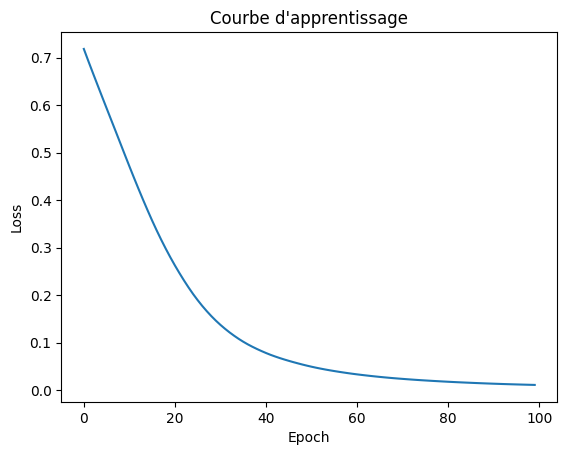

In [15]:
# Données synthétiques pour l'exemple
X = torch.randn(100, 10)
y = (X[:, 0] + X[:, 1] > 0).float().unsqueeze(1)

# Modèle
model = nn.Sequential(
    nn.Linear(10, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

# Fonction de perte
criterion = nn.BCEWithLogitsLoss()

# Optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Boucle d'entraînement
losses = []

for epoch in range(100):
    # 1. Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # 2. Backward pass
    optimizer.zero_grad()  # Reset des gradients
    loss.backward()        # Calcul des gradients
    
    # 3. Mise à jour des poids
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        acc = ((torch.sigmoid(outputs) > 0.5) == y).float().mean()
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | Acc: {acc:.2%}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbe d\'apprentissage')
plt.show()

## 6. Fonctions de Perte

PyTorch fournit plusieurs fonctions de perte :

In [16]:
# Régression
mse_loss = nn.MSELoss()
y_pred = torch.tensor([2.5, 0.0, 2.1])
y_true = torch.tensor([3.0, -0.5, 2.0])
print(f"MSE Loss: {mse_loss(y_pred, y_true):.4f}")

# Classification binaire (avec logits)
bce_loss = nn.BCEWithLogitsLoss()
logits = torch.tensor([0.5, -1.0, 2.0])
labels = torch.tensor([1.0, 0.0, 1.0])
print(f"BCE Loss: {bce_loss(logits, labels):.4f}")

# Classification multi-classe
ce_loss = nn.CrossEntropyLoss()
logits = torch.tensor([[2.0, 1.0, 0.1], [0.5, 2.0, 0.3]])  # 2 samples, 3 classes
labels = torch.tensor([0, 1])  # Classes correctes
print(f"CrossEntropy Loss: {ce_loss(logits, labels):.4f}")

MSE Loss: 0.1700
BCE Loss: 0.3048
CrossEntropy Loss: 0.3788


## 7. Optimiseurs : SGD vs Adam

Comparons les deux optimiseurs les plus courants :

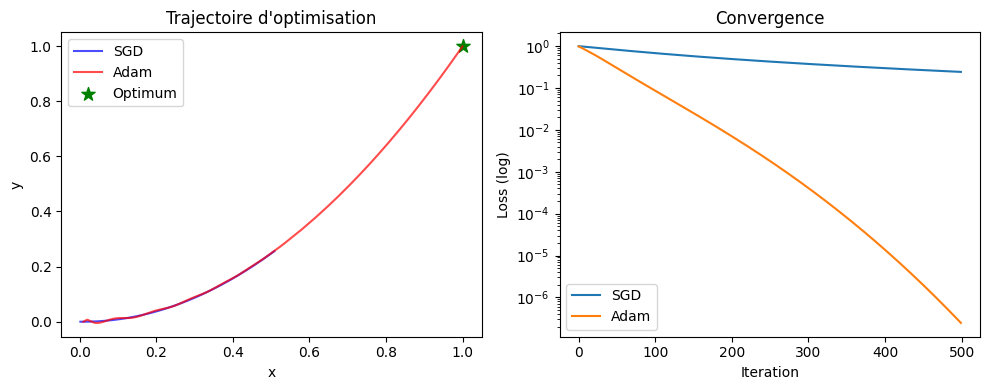

In [17]:
# Fonction à minimiser : f(x) = x^2 + y^2
def rosenbrock(params):
    x, y = params
    return (1 - x)**2 + 100 * (y - x**2)**2

def train_optimizer(opt_class, lr, n_steps=500, **kwargs):
    params = torch.tensor([0.0, 0.0], requires_grad=True)
    optimizer = opt_class([params], lr=lr, **kwargs)
    
    history = []
    for _ in range(n_steps):
        optimizer.zero_grad()
        loss = rosenbrock(params)
        loss.backward()
        optimizer.step()
        history.append(params.detach().clone().numpy())
    
    return np.array(history)

# Comparer SGD et Adam
sgd_history = train_optimizer(optim.SGD, lr=0.001)
adam_history = train_optimizer(optim.Adam, lr=0.01)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(sgd_history[:, 0], sgd_history[:, 1], 'b-', alpha=0.7, label='SGD')
plt.plot(adam_history[:, 0], adam_history[:, 1], 'r-', alpha=0.7, label='Adam')
plt.scatter([1], [1], c='green', s=100, marker='*', label='Optimum')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Trajectoire d\'optimisation')

plt.subplot(1, 2, 2)
sgd_losses = [rosenbrock(torch.tensor(p)).item() for p in sgd_history]
adam_losses = [rosenbrock(torch.tensor(p)).item() for p in adam_history]
plt.semilogy(sgd_losses, label='SGD')
plt.semilogy(adam_losses, label='Adam')
plt.xlabel('Iteration')
plt.ylabel('Loss (log)')
plt.legend()
plt.title('Convergence')

plt.tight_layout()
plt.show()

## 8. Régularisation

Techniques pour éviter l'overfitting :

In [18]:
# Dropout
dropout = nn.Dropout(p=0.3)  # 30% des neurones désactivés

x = torch.ones(1, 10)

# En mode training
dropout.train()
print(f"Train mode: {dropout(x)}")

# En mode eval (pas de dropout)
dropout.eval()
print(f"Eval mode: {dropout(x)}")

Train mode: tensor([[1.4286, 1.4286, 0.0000, 1.4286, 0.0000, 1.4286, 0.0000, 1.4286, 1.4286,
         1.4286]])
Eval mode: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [19]:
# Weight Decay (L2 regularization)
model = nn.Linear(10, 1)

# Sans weight decay
opt_no_wd = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)

# Avec weight decay
opt_with_wd = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

print("Weight decay pénalise les gros poids pour encourager des solutions plus simples")

Weight decay pénalise les gros poids pour encourager des solutions plus simples


## 9. Exercice Final : Préparez-vous pour le Tournoi !

Maintenant, vous avez tous les outils pour participer au Tournoi de la Guilde.

Modifiez le modèle `baseline_model.py` et `train.py` pour améliorer les performances !

In [21]:
# Charger les données du tournoi
import pandas as pd

train_df = pd.read_csv('data/train.csv')
print(f"Dataset d'entraînement: {len(train_df)} aventuriers")
print(f"\nFeatures:")
print(train_df.columns.tolist())
print(f"\nStatistiques:")
train_df.describe()

Dataset d'entraînement: 800 aventuriers

Features:
['force', 'intelligence', 'agilite', 'chance', 'experience', 'niveau_quete', 'equipement', 'fatigue', 'survie']

Statistiques:


,force,intelligence,agilite,chance,experience,niveau_quete,equipement,fatigue,survie
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,49.811826,51.784868,50.272665,49.756025,4.850520,5.573750,39.934163,40.735103,0.551250
std,19.403787,19.903262,19.143065,23.867592,4.900930,2.917653,17.485261,20.181725,0.497678
min,0.000000,0.000000,0.000000,0.000000,0.000154,1.000000,0.000000,0.000000,0.000000
25%,35.953321,38.359399,37.526673,33.484220,1.372126,3.000000,28.118499,26.549234,0.000000
50%,50.255943,51.554571,50.017334,49.039026,3.456198,6.000000,39.270882,40.642608,1.000000
75%,62.573327,64.663990,63.413910,65.665140,6.578142,8.000000,51.129795,54.480324,1.000000
max,100.000000,100.000000,100.000000,100.000000,30.000000,10.000000,100.000000,95.373841,1.000000


## Récapitulatif

| Concept | micrograd | PyTorch |
|---------|-----------|----------|
| Données | `Value` scalaire | `Tensor` N-dim |
| Gradients | `.backward()` manuel | `autograd` automatique |
| Couches | Classes custom | `nn.Module` |
| Optimisation | Boucle manuelle | `optim.Adam/SGD` |

**Prochaine étape** : Le Tournoi de la Guilde !